##Instalación de librerias 

In [ ]:
!pip install PyDrive

In [ ]:
pip install --upgrade category_encoders

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.7/dist-packages (2.2.2)


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import files

##Información del Data set

In [ ]:
id_train_labels = '1o8fEed65R8219m5iOJoZgvHXaTGwWE4H'
id_train_values = "1RCoa3FWbpcHVC6imhaQQFQEAWNW0qkh0" 
id_test_values = '1xBGPZbt3BYxe1OOYGMJuGnXe_pEqFZ1a'
id_submission_format = "1ei8BhsAAhZpZ8sRqEOVGl12y0JAPdXGV"

downloaded_train_labels = drive.CreateFile({'id': id_train_labels})
downloaded_train_values = drive.CreateFile({'id': id_train_values})
downloaded_test_values = drive.CreateFile({'id': id_test_values})
downloaded_submission_format = drive.CreateFile({'id': id_submission_format})

downloaded_train_labels.GetContentFile('train_labels.csv')
downloaded_train_values.GetContentFile('train_values.csv')
downloaded_test_values.GetContentFile('test_values.csv')
downloaded_submission_format.GetContentFile('submission_format.csv')

In [ ]:

train_values = pd.read_csv('train_values.csv', dtype={
    'building_id': 'int64', 'geo_level_1_id': 'int64',
    'geo_level_2_id': 'int64', 'geo_level_3_id': 'int64',
    'count_floors_pre_eq': 'int8', 'age': 'int32',
    'area_percentage': 'int32', 'height_percentage': 'int32',
    'land_surface_condition': 'category', 'foundation_type': 'category',
    'roof_type': 'category', 'ground_floor_type': 'category', 'other_floor_type': 'category',
    'position': 'category', 'plan_configuration': 'category', 'has_superstructure_adobe_mud': 'int8',
    'has_superstructure_mud_mortar_stone': 'int8', 'has_superstructure_stone_flag': 'int8',
    'has_superstructure_cement_mortar_stone': 'int8', 'has_superstructure_mud_mortar_brick': 'int8',
    'has_superstructure_cement_mortar_brick': 'int8', 'has_superstructure_timber': 'int8',
    'has_superstructure_bamboo': 'int8', 'has_superstructure_rc_non_engineered': 'int8',
    'has_superstructure_rc_engineered': 'int8', 'has_superstructure_other': 'int8',
    'has_superstructure_other': 'int8', 'legal_ownership_status': 'category',
    'has_secondary_use': 'bool', 'has_secondary_use_agriculture': 'bool',
    'has_secondary_use_hotel': 'bool', 'has_secondary_use_rental': 'bool',
    'has_secondary_use_institution': 'bool', 'has_secondary_use_school': 'bool',
    'has_secondary_use_industry': 'bool', 'has_secondary_use_health_post': 'bool',
    'has_secondary_use_gov_office': 'bool', 'has_secondary_use_use_police': 'bool',
    'has_secondary_use_other': 'bool', 'count_families': 'int8'
})
train_labels = pd.read_csv('train_labels.csv', dtype={
    'damage_grade': 'int16'
})

test_values = pd.read_csv('test_values.csv', dtype={
    'geo_level_1_id': 'int64',
    'geo_level_2_id': 'int64', 'geo_level_3_id': 'int64',
    'count_floors_pre_eq': 'int8', 'age': 'int32',
    'area_percentage': 'int32', 'height_percentage': 'int32'  

})

In [ ]:
labels_and_values = pd.merge(
    train_labels, train_values, how='inner', on='building_id')

In [ ]:
labels_and_values.head(5)

,building_id,damage_grade,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,3,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,False,False,False,False,False,False,False,False,False,False,False
1,28830,2,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,False,False,False,False,False,False,False,False,False,False,False
2,94947,3,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,False,False,False,False,False,False,False,False,False,False,False
3,590882,2,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,False,False,False,False,False,False,False,False,False,False,False
4,201944,3,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,False,False,False,False,False,False,False,False,False,False,False


Land surface con one hot encoding

In [ ]:

labels_and_values = pd.get_dummies(labels_and_values, columns=['plan_configuration'],drop_first=True)
labels_and_values = pd.get_dummies(labels_and_values, columns=['land_surface_condition'], drop_first=True)
labels_and_values = pd.get_dummies(labels_and_values, columns=['foundation_type'], drop_first=True)

In [ ]:

test_values = pd.get_dummies(test_values, columns=['plan_configuration'],drop_first=True)
test_values = pd.get_dummies(test_values, columns=['land_surface_condition'], drop_first=True)
test_values = pd.get_dummies(test_values, columns=['foundation_type'], drop_first=True)

In [ ]:
labels_and_values.columns

Index(['building_id', 'damage_grade', 'geo_level_1_id', 'geo_level_2_id',
       'geo_level_3_id', 'count_floors_pre_eq', 'age', 'area_percentage',
       'height_percentage', 'roof_type', 'ground_floor_type',
       'other_floor_type', 'position', 'has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'legal_ownership_status', 'count_families', 'has_secondary_use',
       'has_secondary_use_agriculture', 'has_secondary_use_hotel',
       'has_secondary_use_rental', 'has_secondary_use_institution',
       'has_secondary_use_school', 'has_secondary_use_industry',
       'has_secondary_use_health_post', 'has_sec

Tratamiento de age = 995

In [ ]:
labels_and_values = labels_and_values[labels_and_values['age']!=995]

In [ ]:
damage_prediction = labels_and_values['damage_grade']

##Separación de la variable a predecir y los features que nos interesan

**Dejamos solo las columnas que nos interesan, sin damage grade xq es lo que queremos predecir**

In [ ]:
test_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86868 entries, 0 to 86867
Data columns (total 51 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   building_id                             86868 non-null  int64 
 1   geo_level_1_id                          86868 non-null  int64 
 2   geo_level_2_id                          86868 non-null  int64 
 3   geo_level_3_id                          86868 non-null  int64 
 4   count_floors_pre_eq                     86868 non-null  int8  
 5   age                                     86868 non-null  int32 
 6   area_percentage                         86868 non-null  int32 
 7   height_percentage                       86868 non-null  int32 
 8   roof_type                               86868 non-null  object
 9   ground_floor_type                       86868 non-null  object
 10  other_floor_type                        86868 non-null  object
 11  po

In [ ]:
features = labels_and_values[["geo_level_1_id","geo_level_2_id", 'count_floors_pre_eq', 'age', 'area_percentage',
       'height_percentage']]


"""features = labels_and_values[["geo_level_1_id","geo_level_2_id","geo_level_3_id","area_percentage","age","height_percentage","land_surface_condition_o","land_surface_condition_t",'has_superstructure_adobe_mud',
    'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag','has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick',
    'has_superstructure_cement_mortar_brick', 'has_superstructure_timber','has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
    'has_superstructure_rc_engineered', 'has_superstructure_other']]
"""

'features = labels_and_values[["geo_level_1_id","geo_level_2_id","geo_level_3_id","area_percentage","age","height_percentage","land_surface_condition_o","land_surface_condition_t",\'has_superstructure_adobe_mud\',\n    \'has_superstructure_mud_mortar_stone\', \'has_superstructure_stone_flag\',\'has_superstructure_cement_mortar_stone\', \'has_superstructure_mud_mortar_brick\',\n    \'has_superstructure_cement_mortar_brick\', \'has_superstructure_timber\',\'has_superstructure_bamboo\', \'has_superstructure_rc_non_engineered\',\n    \'has_superstructure_rc_engineered\', \'has_superstructure_other\']]\n'

In [ ]:
test_values = test_values[["geo_level_1_id","geo_level_2_id", 'count_floors_pre_eq', 'age', 'area_percentage',
       'height_percentage']]

In [ ]:
#features = labels_and_values

Como hay muchas edificaciones que comparten geo level 1 y geo level 2 (tambien 3 pero es menos relevante que los demas) podemos promediar el daño recibido

##Creación del set de entrenamiento y test

**Dividimos train y test**


El parametro test_size es 0.2 ya que consideramos del data set el 20% para test y el 80% para el set de train

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, damage_prediction, test_size=0.2, random_state=45)

In [ ]:
features.columns

Index(['geo_level_1_id', 'geo_level_2_id', 'count_floors_pre_eq', 'age',
       'area_percentage', 'height_percentage'],
      dtype='object')

In [ ]:
y_train

103873    1
209125    3
19145     2
258048    2
59373     2
         ..
61285     2
137818    2
195198    3
138367    3
254224    2
Name: damage_grade, Length: 207368, dtype: int16

##XGBoost


In [ ]:
XParametros = {'learning_rate' : [0.05,0.20],
               'max_depth' : [3,7],
               'min_child_weight' : [1,5],
               }

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [ ]:
"""def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       do_probabilities = True):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2)
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
        pred = fitted_model.predict_proba(X_test_data)[:,1]
    else:
        pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred"""

"def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, \n                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',\n                       do_probabilities = True):\n    gs = GridSearchCV(\n        estimator=model,\n        param_grid=param_grid, \n        cv=cv, \n        n_jobs=-1, \n        scoring=scoring_fit,\n        verbose=2)\n    fitted_model = gs.fit(X_train_data, y_train_data)\n    \n    if do_probabilities:\n        pred = fitted_model.predict_proba(X_test_data)[:,1]\n    else:\n        pred = fitted_model.predict(X_test_data)\n    \n    return fitted_model, pred"

In [ ]:
model = XGBClassifier()
#model = XGBClassifier(learning_rate=0.15, max_depth=11, min_child_weight=1, n_estimators=150)


In [ ]:
"""model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, 
                                 XParametros, cv=5, scoring_fit='neg_log_loss')

print(model.best_score_)
print(model.best_params_)"""

"model, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, model, \n                                 XParametros, cv=5, scoring_fit='neg_log_loss')\n\nprint(model.best_score_)\nprint(model.best_params_)"

In [ ]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

Importancia de los features para el modelo XGBoost

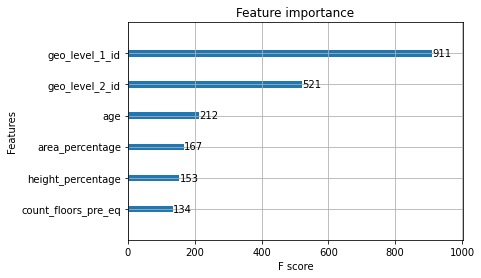

In [ ]:
import matplotlib.pyplot as plt
from xgboost import plot_importance
plot_importance(model, ax=plt.gca())

**Predicciones**

In [ ]:
predicciones = model.predict(X_test)

**Precision**

In [ ]:
f1_score(predicciones, y_test, average='micro')

0.66008911521324

In [ ]:
 pred_train = model.predict(test_values)

In [ ]:
submission_format = pd.read_csv('submission_format.csv', index_col='building_id')

In [ ]:
my_submission = pd.DataFrame(data = pred_train,
                             columns=submission_format.columns,
                             index=submission_format.index)

In [ ]:
my_submission.to_csv('submission.csv')

In [ ]:

#files.download("submission.csv")